In [ ]:
import multirex as mrex # instalar con pip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

: 

In [5]:

## moléculas.

mrex.Util.get_gases() # puede poner un directorio si desea definir dónde descargar, 
# sino pues se descarga en la carpeta madre.

## modelo de estrella
mrex.Util.get_stellar_phoenix() #puede poner un directorio si desea definir dónde descargar
# sino pues se descarga en la carpeta madre.

'''
Si falta alguna molécula pueden ser descargadas de Exomol o Exotransmit.
- https://exomol.com/data/molecules/ , se selecciona la molécula y entrando a la opción recomendada
    se busca el archivo que tenga en la extensión TauREx.
- https://github.com/elizakempton/Exo_Transmit/tree/master/Opac
    Una vez descargado para que se actualice debe volver a correr la función get_gases().
'''
mrex.utils.list_gases()

Available gases in the database:
['DMS', 'N2', 'CO2', 'SO2', 'O2', 'HCN', 'H2O', 'NH3', 'CO', 'NO2', 'CH4', 'O3', 'C2H6', 'CH3Cl']


The directory to Phoenix already exists in the specified path:  d:\Proyectos\IA SpecAtm Bio\Data


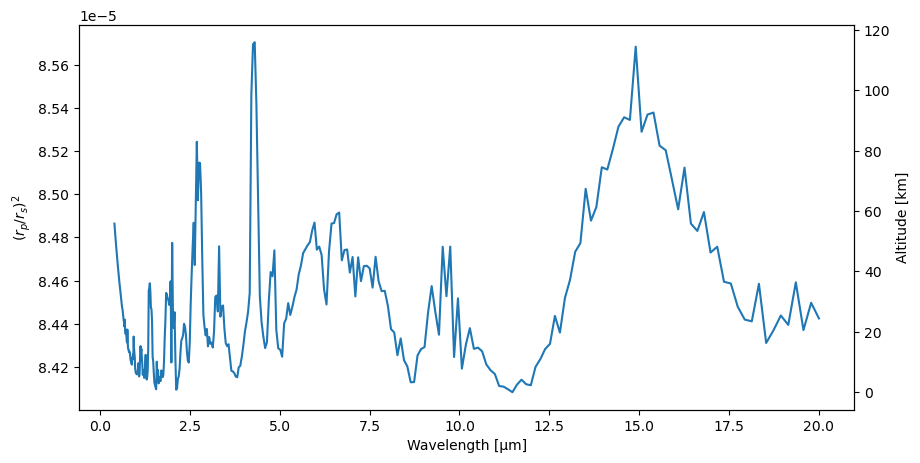

(<Figure size 1000x500 with 2 Axes>,
 <Axes: xlabel='Wavelength [μm]', ylabel='$(r_p/r_s)^2$'>)

In [6]:
Earth = mrex.Planet(
    mass = 1, # Masas terrestres
    radius = 1 # Radios Terrestres
)

Sun = mrex.Star(
    temperature = 5778, # K 
    radius = 1, # Radio Solar
    mass = 1, # Masas solares
    phoenix_path= '' # Cargamos los modelos Phoenix descargados
)

atmo = mrex.Atmosphere(
    temperature = 283, # K ## Temperatura isotérmica
    base_pressure = 1e5, #Pa ## BOA
    top_pressure = 1e-1, # Pa ## TOA
    fill_gas = ["N2"],
)


## mixing ratios en escala logarítmica
atmo.set_composition({
    "CO2":np.log10(3.65e-4),
    "CH4":np.log10(1.65e-6),
    "O2": np.log10(2.1e-1),
    "O3": np.log10(5.5e-8),
    "O2": np.log10(2.1e-1),
    "H2O":-4
    })

Earth.set_atmosphere(atmo)


sistema = mrex.System(Earth,Sun,sma=1)
sistema.get_params()

wn_grid=np.sort(1e4/(np.logspace(np.log10(0.4),np.log10(20),3*60*2)))
sistema.make_tm()


# AÑADIR CIA, normalmente para planetas gasesos se agregan los de H2-H2, H2-He
# pero toca buscar pues en modelos 

# Descargar los CIA de Hitran
# https://hitran.org/cia/
cia_path = "CIA"
from taurex.cache import OpacityCache,CIACache
CIACache().set_cia_path(cia_path)
import taurex.contributions
sistema.transmission.add_contribution(taurex.contributions.CIAContribution([
    'N2-N2',
    'O2-O2',
    "CO2-CO2"]))
sistema.transmission.build()

sistema.plot_spectrum(wn_grid,True)


## spectra with individual contributions

Esto es para visualizar por contribución de molécula.

dict_keys(['Absorption', 'Rayleigh', 'CIA'])
CO2
8.405051369656294e-05
CH4
8.405018024526482e-05
H2O
8.405020790126434e-05
O2
8.408896781093283e-05
N2
8.414580384166847e-05


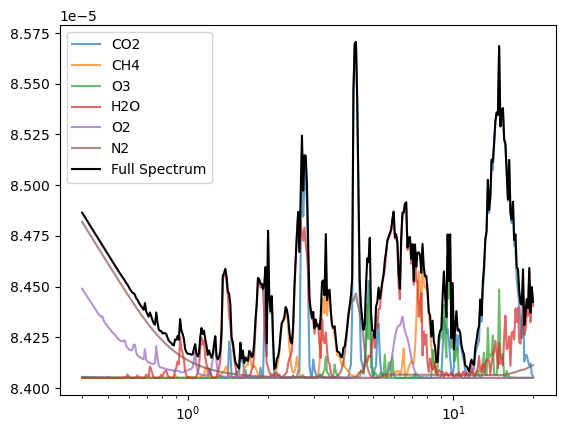

In [7]:
import numpy as np
import matplotlib.pyplot as plt

contrib = sistema.generate_contributions(wn_grid)
print(contrib[1].keys())

## Esto lo hice a mano casi :V
# listar las moléculas involucradas
mol = ['CO2', 'CH4', 'O3', 'H2O', "O2", "N2"]

for m in mol:
    
    #aborción
    total_contrib = np.array(contrib[1]["Absorption"][m])
    
    #Rayleigh
    if  m in contrib[1]["Rayleigh"].keys():
        print(m)
        print(np.mean(contrib[1]["Rayleigh"][m]))
        total_contrib += np.array(contrib[1]["Rayleigh"][m]) - min(contrib[1]["Rayleigh"][m])
    
    # CIA
    # Recomiendo revisar esta parte, porque lo hice así porque no tengo CIA entre dos moléculas
    # entonces tal vez toque modificarlo para que se ajuste a su caso.
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        total_contrib += np.array(contrib[1]["CIA"][f"{m}-{m}"])-min(contrib[1]["CIA"][f"{m}-{m}"])
    
    # Graficar la contribución total para cada molécula
    plt.plot(1e4/contrib[0], total_contrib, label=m, alpha=0.7)
    
## plot full spectrum
## full spectrum
full_spec = sistema.generate_spectrum(wn_grid)
plt.plot(1e4/full_spec[0],full_spec[1],label="Full Spectrum",color="black")

plt.legend()
plt.xscale("log")
plt.show()


In [10]:
## save contrib and full spectrum

import joblib
joblib.dump(contrib,"contrib.pkl")
joblib.dump(full_spec,"full_spec.pkl")



['full_spec.pkl']

## functions midi

Aquí están las funciones que se usan para convertir las moléculas en sonidos.

In [17]:
def create_pentatonic_scale_with_octaves():
    # si quiere cambia de escala, o cambiar el número de octavas o correrlas a más
    # graves o agudas
    return ['silence',
            'D1', 'E1', 'G1', 'A2', 'C2',
            'D2', 'E2', 'G2', 'A3', 'C3',
            'D3', 'E3', 'G3', 'A4', 'C4',
            'D4', 'E4', 'G4', 'A5', 'C5']

# Mapeo del espectro a la escala pentatónica
def map_spectrum_to_pentatonic_scale(spectrum, min_val, max_val):
    # Es impportante definir el valor min y max porque sino cada molécula 
    # quededaría normalizada sin considerar la proporción global en el espectro
    # y la idea es conservar la relación  de absorción entre las moléculas.
    p_scale = create_pentatonic_scale_with_octaves()
    norm_spectrum = (spectrum - min_val) / (max_val - min_val)
    norm_spectrum = np.clip(norm_spectrum, 0, 1)
    note_indices = (norm_spectrum * (len(p_scale) - 1)).astype(int)
    mapped_spectrum = [p_scale[i] for i in note_indices]
    return mapped_spectrum


### Crear archivo MIDI

def create_midi_file(molecule, pen_mol_spec, file_name):
    midi = MIDIFile(1)  # Crear un archivo MIDI con una pista
    track = 0 # Pista 0
    time = 0
    midi.addTrackName(track, time, f"{molecule} Spectrum")
    midi.addTempo(track, time, 90)
    

    # Invertir pen mol spec
    pen_mol_spec = pen_mol_spec[::-1]

    for note in pen_mol_spec:
        if note != "silence":
            note_name, octave = note[:-1], int(note[-1])
            midi_note = note_to_midi(note_name, octave)
            midi.addNote(track, 0, midi_note, time, 0.5 , 100)
        
        else: 
            midi.addNote(track, 0, 0, time, 0.5, 0)
        time += 0.5


    with open(file_name, "wb") as output_file:
        midi.writeFile(output_file)

def note_to_midi(note, octave):
    note_dict = {'C': 0, 'C#': 1, 'D': 2, 'D#': 3,
                 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 
                 'G#': 8, 'A': 9, 'A#': 10, 'B': 11}
    midi_number = (octave + 1) * 12 + note_dict[note]
    return midi_number


def create_note_to_sequential_dict():
    scale = create_pentatonic_scale_with_octaves()
    note_to_sequential_dict = {note: i+1 for i, note in enumerate(scale)}
    return note_to_sequential_dict


def map_spectrum_to_sequential_scale(spectrum, min_val, max_val):
    p_scale = create_pentatonic_scale_with_octaves()
    norm_spectrum = (spectrum - min_val) / (max_val - min_val)
    norm_spectrum = np.clip(norm_spectrum, 0, 1)
    note_indices = (norm_spectrum * (len(p_scale) - 1)).astype(int)
    mapped_spectrum = [p_scale[i] for i in note_indices]
    note_to_sequential_dict = create_note_to_sequential_dict()
    sequential_mapped_spectrum = [note_to_sequential_dict[note] for note in mapped_spectrum]
    return sequential_mapped_spectrum, mapped_spectrum

Prueba del mapeo

In [12]:
_,full_spec = sistema.generate_spectrum(wn_grid)

min_spec = np.min(full_spec)
max_spec = np.max(full_spec)

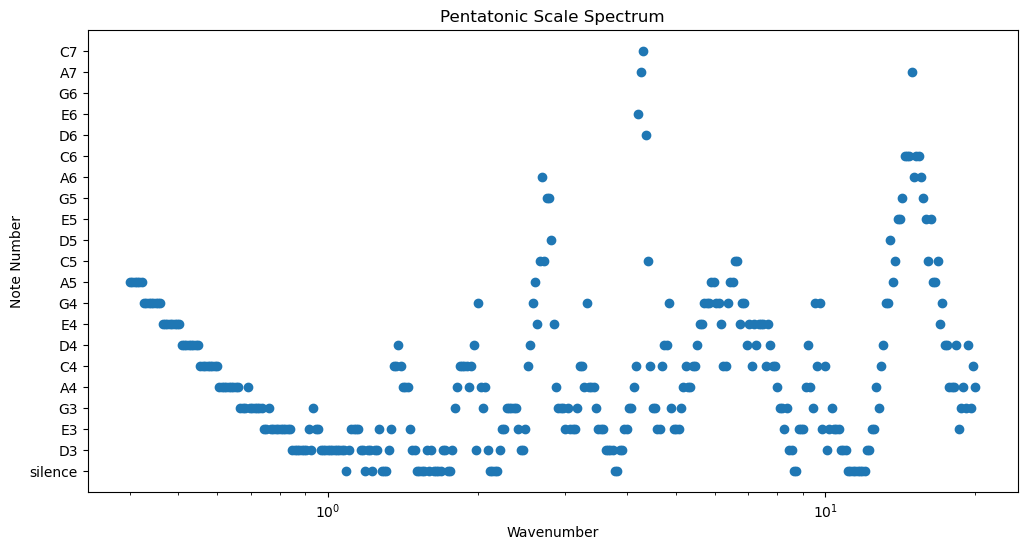

In [14]:
# Mapear el espectro a la escala pentatónica secuencial
sequential_pen_spec, pen_spec = map_spectrum_to_sequential_scale(full_spec, min_spec, max_spec)

# Graficar la escala pentatónica
plt.figure(figsize=(12, 6))
plt.scatter(1e4/wn_grid, sequential_pen_spec)
plt.xlabel("Wavenumber")
plt.ylabel("Note Number")
plt.title("Pentatonic Scale Spectrum")
plt.xscale("log")

# Definir los ticks y etiquetas del eje y
note_to_sequential_dict = create_note_to_sequential_dict()
plt.yticks(ticks=list(note_to_sequential_dict.values()), labels=list(note_to_sequential_dict.keys()))

plt.show()

## sounds per molecule

visualización de los sonidos por molécula

CO2 360
CH4 360
O3 360
H2O 360
O2 360
N2 360


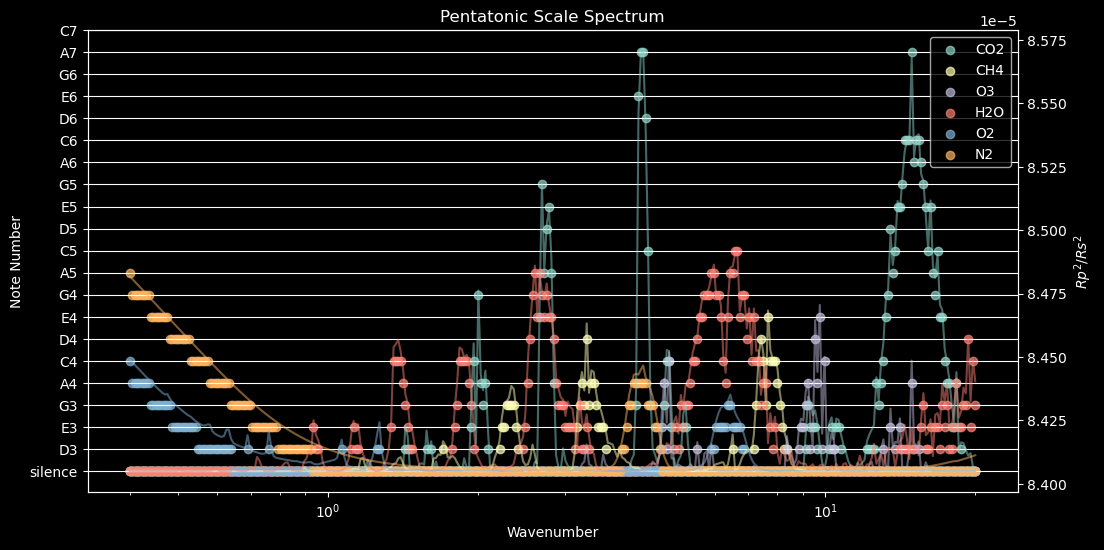

In [20]:
# Generar contribuciones y espectro completo
contrib = sistema.generate_contributions(wn_grid)
_, full_spec = sistema.generate_spectrum(wn_grid)

min_spec = np.min(full_spec)
max_spec = np.max(full_spec)

mol = ['CO2', 'CH4', 'O3', 'H2O', "O2", "N2"]
plt.figure(figsize=(12, 6))
## make style black
plt.style.use('dark_background')
# Graficar la escala pentatónica para cada molécula
for m in mol:
    mol_contrib = contrib[1]["Absorption"][m].copy()
    if m in contrib[1]["Rayleigh"].keys():
        mol_contrib += contrib[1]["Rayleigh"][m] - np.min(contrib[1]["Rayleigh"][m])
        
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        mol_contrib += contrib[1]["CIA"][f"{m}-{m}"] - np.min(contrib[1]["CIA"][f"{m}-{m}"])
    
    #save mol contrib as f_{m}.txt
    np.savetxt(f"{m}.txt",mol_contrib)
    
    pen_mol_spec, _ = map_spectrum_to_sequential_scale(mol_contrib, min_spec, max_spec)
    plt.scatter(1e4/wn_grid, pen_mol_spec, label=m, alpha=0.7)
    print(m, len(pen_mol_spec))

plt.legend()
plt.xlabel("Wavenumber")
plt.ylabel("Note Number")
plt.title("Pentatonic Scale Spectrum")

# Definir los ticks y etiquetas del eje y
note_to_sequential_dict = create_note_to_sequential_dict()
plt.yticks(ticks=list(note_to_sequential_dict.values()), labels=list(note_to_sequential_dict.keys()))
plt.grid(axis='y')

# Añadir eje secundario
ax2 = plt.twinx()
ax2.set_ylabel("$Rp^2/Rs^2$")

for m in mol:
    mol_contrib = contrib[1]["Absorption"][m].copy()
    if m in contrib[1]["Rayleigh"].keys():
        mol_contrib += contrib[1]["Rayleigh"][m] - np.min(contrib[1]["Rayleigh"][m])
        
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        mol_contrib += contrib[1]["CIA"][f"{m}-{m}"] - np.min(contrib[1]["CIA"][f"{m}-{m}"])
    
    ax2.plot(1e4/wn_grid, mol_contrib, label=m, alpha=0.5)
    
plt.xscale("log")

plt.show()

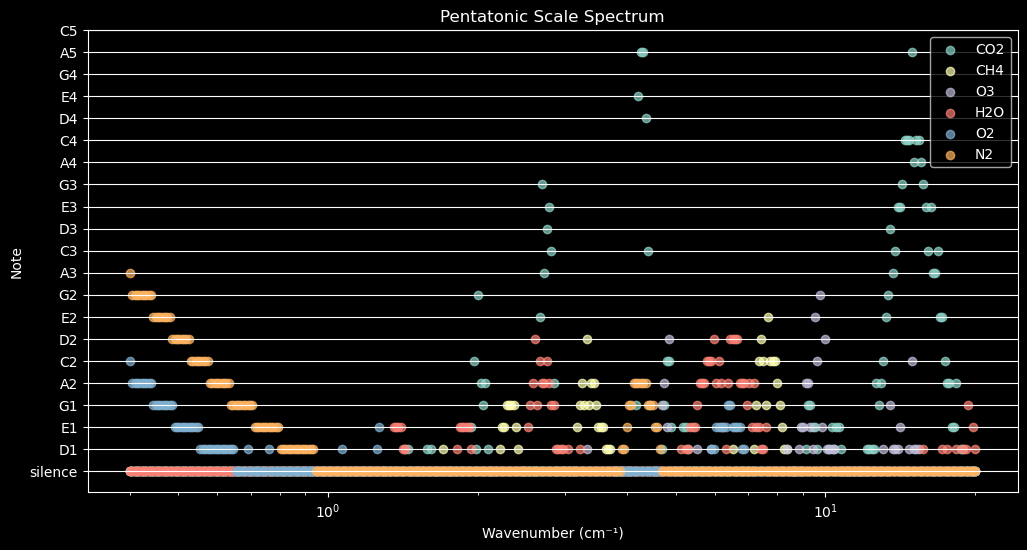

In [21]:
# Generar y exportar espectro en escala pentatónica
_, full_spec = sistema.generate_spectrum(wn_grid)
min_spec = np.min(full_spec)
max_spec = np.max(full_spec)

# Visualizar el espectro mapeado a la escala pentatónica
plt.figure(figsize=(12, 6))
## make style black
plt.style.use('dark_background')
for m in mol:
    mol_contrib = contrib[1]["Absorption"][m].copy()
    if m in contrib[1]["Rayleigh"].keys():
        mol_contrib += contrib[1]["Rayleigh"][m] - np.min(contrib[1]["Rayleigh"][m])
        
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        mol_contrib += contrib[1]["CIA"][f"{m}-{m}"] - np.min(contrib[1]["CIA"][f"{m}-{m}"])
    
    pen_mol_spec = map_spectrum_to_pentatonic_scale(mol_contrib, min_spec, max_spec)
    
    note_to_sequential_dict = {note: i+1 for i, note in enumerate(create_pentatonic_scale_with_octaves())}
    sequential_pen_mol_spec = [note_to_sequential_dict[note] for note in pen_mol_spec]
    
    plt.scatter(1e4 / wn_grid, sequential_pen_mol_spec, label=m, alpha=0.7)

# Etiquetas del eje y
note_to_sequential_dict = {note: i+1 for i, note in enumerate(create_pentatonic_scale_with_octaves())}
plt.yticks(ticks=list(note_to_sequential_dict.values()), labels=list(note_to_sequential_dict.keys()))

plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Note")
plt.title("Pentatonic Scale Spectrum")
plt.xscale("log")
plt.legend(loc="upper right")
plt.grid(axis='y')
plt.show()


## MIDIS

Archivo MIDI para CO2 generado: CO2_spectrum.mid
Archivo MIDI para CH4 generado: CH4_spectrum.mid
Archivo MIDI para O3 generado: O3_spectrum.mid
Archivo MIDI para H2O generado: H2O_spectrum.mid
Archivo MIDI para O2 generado: O2_spectrum.mid
Archivo MIDI para N2 generado: N2_spectrum.mid


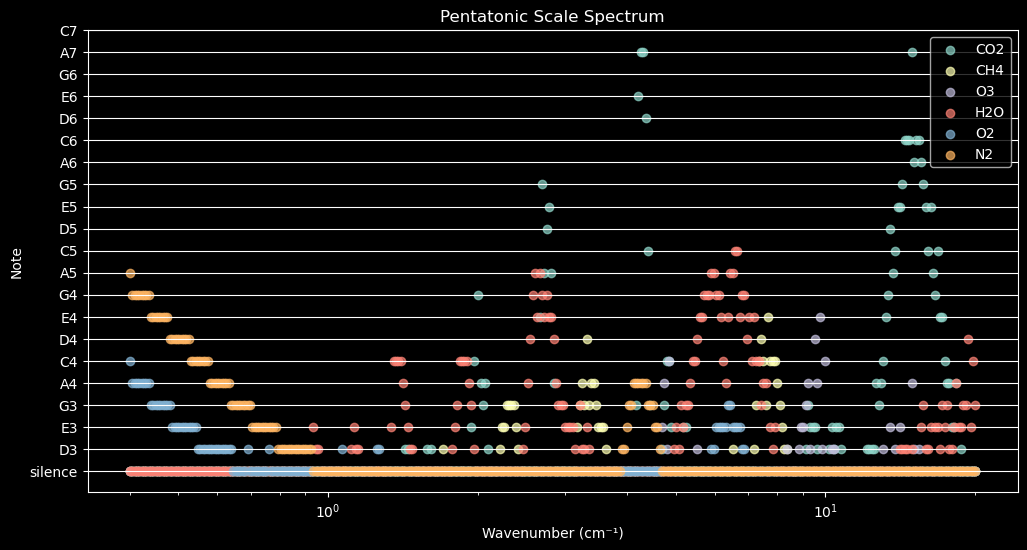

In [19]:
from midiutil import MIDIFile

# tomamos el espectro completo para tener el min y max
_, full_spec = sistema.generate_spectrum(wn_grid)
min_spec = np.min(full_spec)
max_spec = np.max(full_spec)

## cargamos las contribuciones
contrib = sistema.generate_contributions(wn_grid)


## Creamos archivo midi por cada molécula
## ES IMPORTANTE EL COMENTARIO QUE DI DE LAS CIA
for m in mol:
    # absorcion
    mol_contrib = contrib[1]["Absorption"][m].copy()
    # Rayleigh
    if m in contrib[1]["Rayleigh"].keys():
        mol_contrib += contrib[1]["Rayleigh"][m] - np.min(contrib[1]["Rayleigh"][m])
    
    # CIA    
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        mol_contrib += contrib[1]["CIA"][f"{m}-{m}"] - np.min(contrib[1]["CIA"][f"{m}-{m}"])
    pen_mol_spec = map_spectrum_to_pentatonic_scale(mol_contrib, min_spec, max_spec)
    file_name = f"{m}_spectrum.mid"
    create_midi_file(m, pen_mol_spec, file_name)
    print(f"Archivo MIDI para {m} generado: {file_name}")

# Visualizar el espectro mapeado a la escala pentatónica
plt.figure(figsize=(12, 6))
for m in mol:
    mol_contrib = contrib[1]["Absorption"][m].copy()
    if m in contrib[1]["Rayleigh"].keys():
        mol_contrib += contrib[1]["Rayleigh"][m] - np.min(contrib[1]["Rayleigh"][m])
        
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        mol_contrib += contrib[1]["CIA"][f"{m}-{m}"] - np.min(contrib[1]["CIA"][f"{m}-{m}"])
    
    pen_mol_spec = map_spectrum_to_pentatonic_scale(mol_contrib, min_spec, max_spec)
    
    note_to_sequential_dict = {note: i+1 for i, note in enumerate(create_pentatonic_scale_with_octaves())}
    sequential_pen_mol_spec = [note_to_sequential_dict[note] for note in pen_mol_spec]
    
    plt.scatter(1e4 / wn_grid, sequential_pen_mol_spec, label=m, alpha=0.7)

# Etiquetas del eje y
note_to_sequential_dict = {note: i+1 for i, note in enumerate(create_pentatonic_scale_with_octaves())}
plt.yticks(ticks=list(note_to_sequential_dict.values()), labels=list(note_to_sequential_dict.keys()))

plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Note")
plt.title("Pentatonic Scale Spectrum")
plt.xscale("log")
plt.legend(loc="upper right")
plt.grid(axis='y')
plt.show()


Guardar los espectros para animación

In [ ]:
for m in mol:
    mol_contrib = contrib[1]["Absorption"][m].copy()
    if m in contrib[1]["Rayleigh"].keys():
        mol_contrib += contrib[1]["Rayleigh"][m] - np.min(contrib[1]["Rayleigh"][m])
        
    if m in ['CO2', 'N2', 'O2'] and f"{m}-{m}" in contrib[1]["CIA"].keys():
        mol_contrib += contrib[1]["CIA"][f"{m}-{m}"] - np.min(contrib[1]["CIA"][f"{m}-{m}"])
    pen_mol_spec = map_spectrum_to_pentatonic_scale(mol_contrib, min_spec, max_spec)
    ## save txt pen_{mol}.txt
    np.savetxt(f"pen_{m}.txt", pen_mol_spec, fmt="%s")
    